---
title: "Model Selection: Grid & Random Search"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

We have discussed many evaluation methods in detail, and how to apply them given the ground truth and a model. However, we often want to use our metrics in model selection using `GridSearchCV` or `cross_val_score`. Luckily `scikit-learn` provides a very simple way to achieve this, via the scoring argument that can be used in both `GridSearchCV` and `cross_val_score`. You can simply provide a string describing the evaluation metric you want to use.

In [3]:
#| label: tbl-raw-dataset
#| tbl-cap: Iris Dataset
#| code-fold: true

from sklearn import datasets
iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Add target
df['target'] = iris.target

# Dictionary
target_names_dict = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

# Add the target names column to the DataFrame
df['target_names'] = df['target'].map(target_names_dict)
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target vs Inputs
X = df.drop(columns=["target", "target_names"]) # Covariates-Only
y = df["target"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=0)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


# 1. Grid Search

Grid search involves specifying a list of hyperparameters and their possible values. Then, the algorithm exhaustively tries all possible combinations of hyperparameters to find the best set. This technique is simple but computationally expensive, especially with many hyperparameters.

- We define the hyperparameters we want to tune and their possible values in the `param_grid` dictionary. In this case, we are tuning `'n_estimators'`, `'max_features'`, and `'criterion'`; for example, `'n_estimators'` can take one of these three values: `100`, `500`, and `1000`.

## 1.1. Hyperparameter Tuning

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters and their possible values 
param_grid = {'n_estimators': [10, 50, 100],
              'max_features': [None,'sqrt', 'log2'], 
              'criterion': ['gini','entropy']}
param_grid

{'n_estimators': [10, 50, 100],
 'max_features': [None, 'sqrt', 'log2'],
 'criterion': ['gini', 'entropy']}

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Create the model you want to tune
model = RandomForestClassifier(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X, y)  # Replace X and y with your data

# Get the best hyperparameters for Random Forest
best_params_rf = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best performance:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
Best performance: 0.9666666666666668


In [7]:
#| code-fold: true

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Visualizisation Block
def plot_tuning_results(df_val):
    
    df_temp = df_val[:][df_val.max_features != 'sqrt'].sort_values(by=['n_estimators', 'criterion'])
    df_none = df_temp[:][df_temp.max_features != 'log2'].sort_values(by=['n_estimators', 'criterion'])
    df_sqrt = df_val[:][df_val.max_features == 'sqrt'].sort_values(by=['n_estimators', 'criterion'])
    df_log2 = df_val[:][df_val.max_features == 'log2'].sort_values(by=['n_estimators', 'criterion'])

    pivot1 = df_none.pivot_table(index='n_estimators',columns='criterion',values='accuracy')
    pivot2 = df_sqrt.pivot_table(index='n_estimators',columns='criterion',values='accuracy')
    pivot3 = df_log2.pivot_table(index='n_estimators',columns='criterion',values='accuracy')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

    sns.heatmap(pivot1,vmin=0.45,vmax=0.65,annot=True,linewidths=0.4,ax=ax1,cmap="coolwarm_r")
    sns.heatmap(pivot2,vmin=0.45,vmax=0.65,annot=True,linewidths=0.4,ax=ax2,cmap="coolwarm_r")
    sns.heatmap(pivot3,vmin=0.45,vmax=0.65,annot=True,linewidths=0.4,ax=ax3,cmap="coolwarm_r")
    
    ax1.set_title("max_features: none")
    ax3.set_title("max_features: log2")
    ax2.set_title("max_features: sqrt")

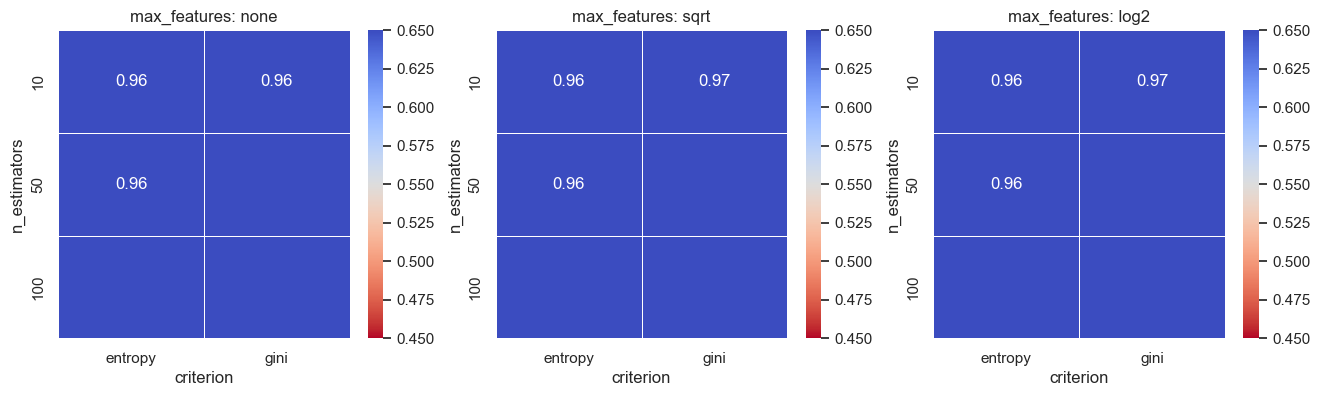

In [8]:
#| label: fig-gridsearch
#| fig-cap: Grid Search Results
#| code-fold: true

df_grid = pd.DataFrame(grid_search.cv_results_["params"])
df_grid['accuracy'] = np.round(grid_search.cv_results_["mean_test_score"],2)
plot_tuning_results(df_grid)

More Hyperparameters:

In [22]:
from scipy.stats import randint

param_grid_rf = {
    #'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Regressor
model = RandomForestClassifier(random_state=42)

# Perform grid search cross-validation for Random Forest
grid_search_rf = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your data
grid_search_rf.fit(X, y)  

# Get the best hyperparameters for Random Forest
best_params_rf = grid_search_rf.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)
print("Best performance:", grid_search_rf.best_score_)

Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best performance: -0.03333333333333333


## 1.2. Run Selected Model

In [26]:
from sklearn.model_selection import cross_validate

# Initialize
rf_regressor = RandomForestClassifier(max_depth = best_params_rf['max_depth'],
                                      min_samples_split = best_params_rf['min_samples_split'],
                                      min_samples_leaf = best_params_rf['min_samples_leaf'],
                                      max_features = best_params_rf['max_features'],
                                      random_state = 42)

# Cross validation and performance evaluation
rmse_rf = cross_validate(rf_regressor, X, y, cv=5, scoring='accuracy') 

# Average
rmse_rf = pd.DataFrame(rmse_rf)
print( rmse_rf["test_score"].mean().round(2) )

0.97


# 2. Random Search

Random search involves randomly selecting hyperparameter values from predefined ranges. It doesn't explore all possible combinations like grid search but can be more efficient and is often effective.

## 2.1. Hyperparameter Tuning

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid
param_dist = {'n_estimators': [10, 50, 100], 
              'max_features': [None,'sqrt', 'log2'], 'criterion': ['gini','entropy']}

# Create a Random Forest classifier
model= RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=8,  # Number of random combinations to try
    cv=5,         # Number of cross-validation folds
)

# Fit the RandomizedSearchCV to your data
random_search.fit(X, y)

# Print the best hyperparameters found by Random Search
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best hyperparameters for Random Forest
best_params_rf = grid_search_rf.best_params_


random_search.best_score_

Best Hyperparameters: {'n_estimators': 50, 'max_features': 'log2', 'criterion': 'gini'}
Best Score: 0.9666666666666668


0.9666666666666668

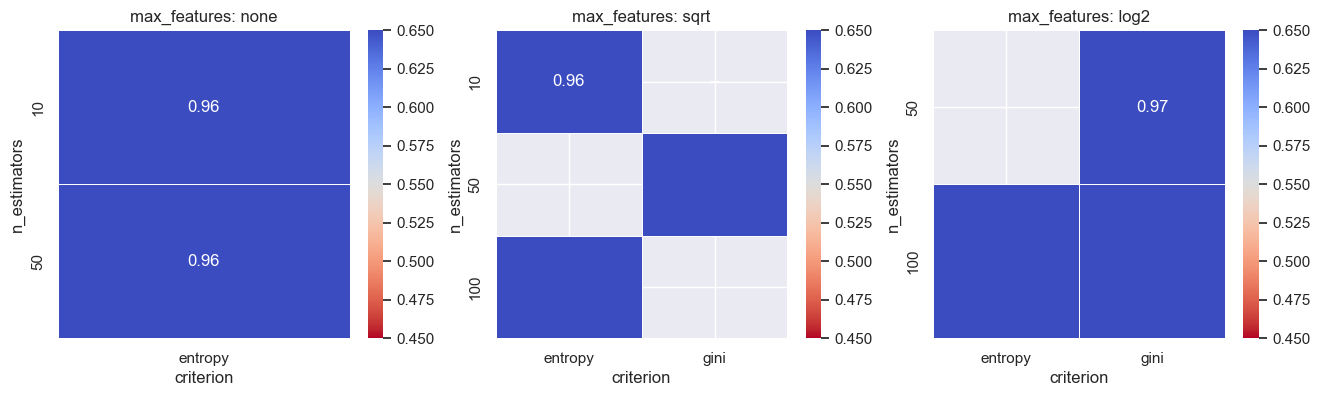

In [28]:
#| label: fig-randomsearch
#| fig-cap: Random Search Results
#| code-fold: true

df_random = pd.DataFrame(random_search.cv_results_["params"])
df_random['accuracy'] = np.round(random_search.cv_results_["mean_test_score"],2)
plot_tuning_results(df_random)

## 2.2. Run Selected Model

In [30]:
from sklearn.model_selection import cross_validate

# Initialize
rf_regressor = RandomForestClassifier(max_depth = best_params_rf['max_depth'],
                                      min_samples_split = best_params_rf['min_samples_split'],
                                      min_samples_leaf = best_params_rf['min_samples_leaf'],
                                      max_features = best_params_rf['max_features'],
                                      random_state = 42)

# Cross validation and performance evaluation
rmse_rf = cross_validate(rf_regressor, X, y, cv=5, scoring='accuracy') 

# Average
rmse_rf = pd.DataFrame(rmse_rf)
print( rmse_rf["test_score"].mean().round(2) )

0.97
